<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EA%B8%88%EC%9C%B5%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EC%BF%A1%EB%B6%81/3%EC%9E%A5_%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
!pip install quandl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 1.6 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.4 which is incompatible.


In [56]:
import pandas as pd
import quandl

from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

import matplotlib.pyplot as plt

In [4]:
NASDAQ_KEY = 'moGvN9TevWmyAKzhBX1C'
quandl.ApiConfig.api_key=NASDAQ_KEY

# 시계열 분해

**목적**

* 시계열을 여러 구성 요소로 나눠 데이터에 대한 이해를 높이는 것

* 이를 통해 모델링의 복잡성과 각 구성 요소를 정확하게 캡쳐하고자 따라야 하는 접근 방식에 대한 통찰력을 얻을 수 있다

**구성 요소**

* 체계적 구성 요소
  * 레벨 
    * 게열의 평균값
  * 추세
    * 추세의 추정치
    * 특정 시점에서 
    * 연속 시점 사이의 값 변화
    * 시계열의 기울기와 연관될 수 있다
  * 계절성
    * 단기 사이클로 반복되는 평균으로부터의 편차

* 비체계적 구성 요소
  * 노이즈
    * 시계열상의 랜덤 변화

  

**시계열 분해에 사용되는 모델**

* 가산적 모델
  * 모델의 식 : Y = 레벨 + 추세 + 계절성 + 노이즈
  * 선형 모델 : 시간에 따른 크기 변화가 일정
  * 추세는 선형이다
  * 시간 주기에 대해 동일한 빈도와 폭을 가진 선형 계절성

* 승산적 모델
  * 모델의 식 : Y = 레벨 * 추세 * 계절성 * 잡음
  * 비선형 모델 : 시간에 따른 크기 변화가 일정하지 않음
  * 곡선이며 비선형 추세를 가진다
  * 시간 주기에 대해 증가/감소하는 빈도와 폭을 가지는 비선형 계절성

In [7]:
# 2011 ~ 2021 사이의 금 시세
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
                start_date='2011-01-01',
                end_date='2021-12-31')

df.rename(columns={'Value':'price'}, inplace=True)
df = df.resample('M').last()

In [8]:
df.head()

,price
Date,
2011-01-31,1356.40
2011-02-28,1372.73
2011-03-31,1424.01
2011-04-30,1473.81
2011-05-31,1510.44


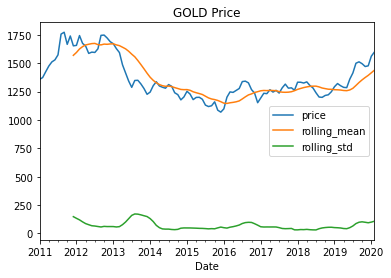

In [9]:
# 이동 평균과 표준 편차
WINDOW_SIZE = 12

df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()

df.plot(title='GOLD Price')

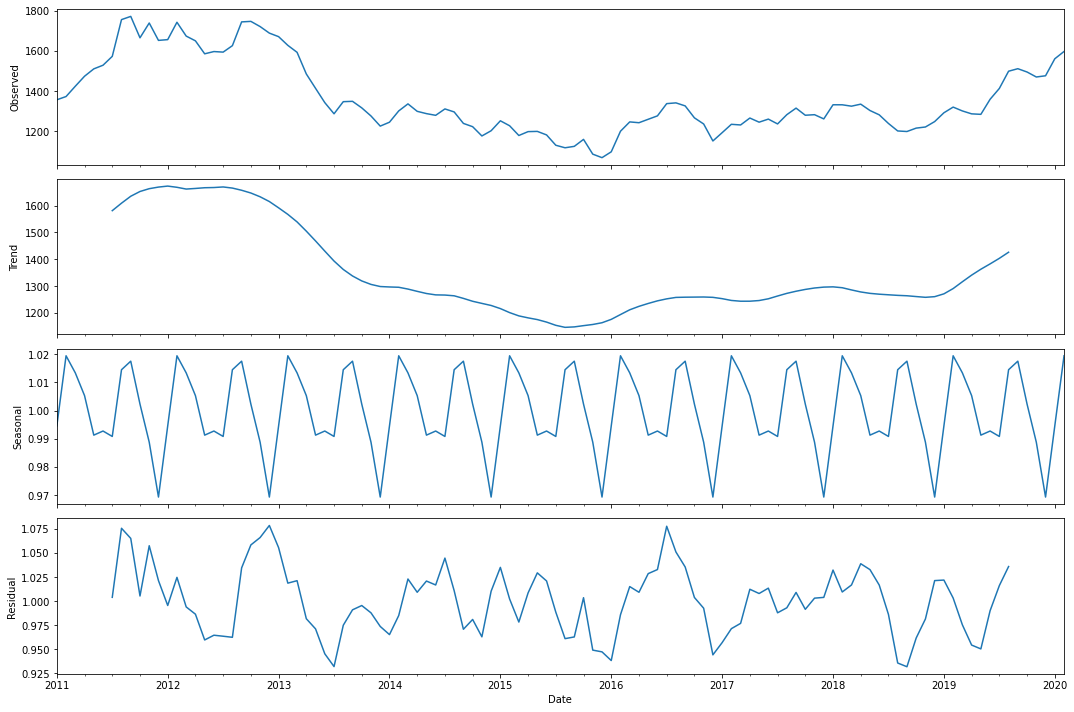

In [21]:
# 승산적 모델을 활용한 계절성 분해
plt.rcParams['figure.figsize']=15,10

decomposition_results = seasonal_decompose(df.price, model='multiplicative')

fig = decomposition_results.plot()

# 페이스북의 Prohet을 사용한 시계열 분해

In [44]:
# 2014 ~ 2019 사이의 금 일별 시세
df = quandl.get(dataset='WGC/GOLD_DAILY_USD',
                start_date='2014-01-01',
                end_date='2019-12-31')

df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date':'ds', 'Value':'y'}, inplace=True)

In [45]:
# 훈련과 테스트 셋 나눔
train_indices = df.ds.apply(lambda x : x.year).values < 2019
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [46]:
df_train.shape, df_test.shape

((1304, 2), (261, 2))

In [57]:
# 모델의 인스턴스를 만들고 데이터를 학습시킴
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl8xsk5nm/zum1g9ur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl8xsk5nm/dtp9y_hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79535', 'data', 'file=/tmp/tmpl8xsk5nm/zum1g9ur.json', 'init=/tmp/tmpl8xsk5nm/dtp9y_hz.json', 'output', 'file=/tmp/tmpacc419qy/prophet_model-20220805023833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:38:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:38:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


* 검은 점 : 금 가격의 실제 관측값
* 파란선 : 적합화를 나타냄 -> 정확히 일치하지 않음
  * 모델이 데이터의 노이즈를 평활화해서 제거했기 때문(과적합 줄임)
* Prophet이 불확실성을 정량화함 -> 파란색 간격으로 표시

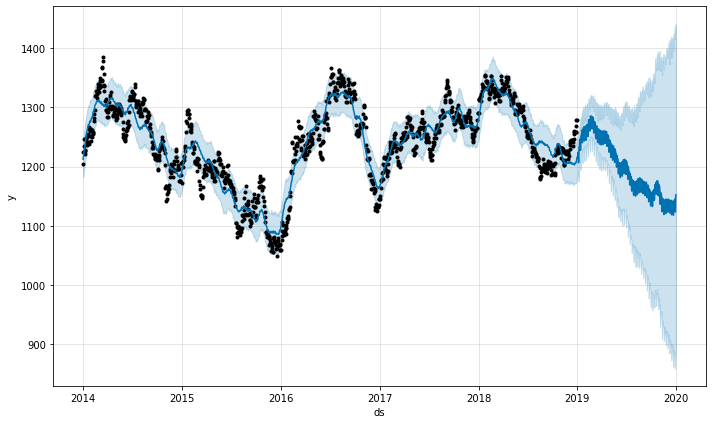

In [58]:
# 금 가격을 예측하고 결과를 도식화한다
df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

plt.show()

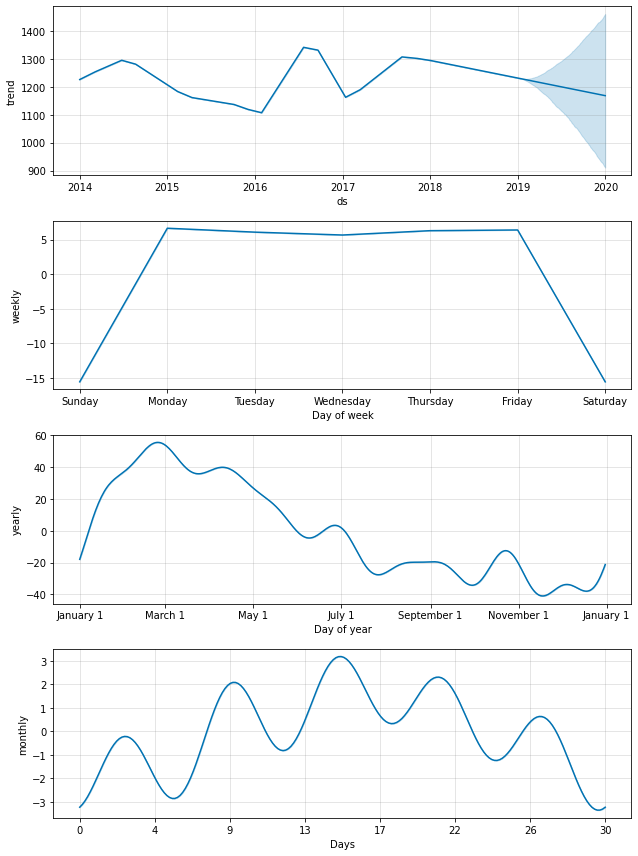

In [60]:
# 시계열 분해
fig = model_prophet.plot_components(df_pred)